Forecasting Stocks with FBProphet

In this notebook I will be utilizing FBProphet with a dataset from kaggle on the S&P 500 https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks to:


*   Explore the recent returns, components and volatility of the index
*   Identify top and bottom stocks based on their performance
*   Create a time series regression model for future forecast

**Time-series data** is used to analyze trends, forecast future values, and develop mathematical models. It can also be used to identify correlations and patterns in data.  Some examples of time-series data are economic indicators, application performance monitoring, daily stock market closing prices. Time-series forecasting involves predicting future values using current and historical data. There are four components of time-series:

1.  Seasonality: Data with seasonality exhibits regular and predictable movement after a fixed period of time
2.  Irregularity: When trend-cycle and seasonal components are removed from time series, there is an irregularity in the residuals
3.  Trend: Increasing or decreasing data; can be linear or nonlinear (logistics growth)
4.  Cyclic: Cyclic patterns occur when data experiences regular or period fluctuations (regular or periodic fluctuations in data).

**Prophet, formerly fbprophet**, is an open source package intended to help you with time series forecasting as a scale with ease.  It is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.  With three primary components—seasonal, trends, holidays or events effect, and error—the decomposable time series model used by Prophet may be broken down into the following equation:

**f(x)=g(x)+s(x)+h(x)+e(t)**

Prophet uses time as a regressor and attempts to fit multiple nonlinear and linear function of time as components. Before choosing to use Prophet it is important that a few criterias are met:

Strong seasonalities(day of the week and time of the year)


*   Strong seasonalities(day of the week and time of the year)
*   Hourly, daily, and weekly observation within at a few months (minimum of 1 month); 1 year of historical data will provide optimal results
*   A good number missing or outlier data
*   Changes in historical trends

If these criterias have been met then jump in and see for yourself the magic of FBProphet.





In [2]:
!pip install prophet

In [3]:
!pip install prophet # make sure you install the prophet package
                      # fbprophet is deprecated.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

from prophet import Prophet # change fbprophet to prophet
from prophet.plot import plot_plotly # change fbprophet to prophet
from prophet.plot import plot_yearly # change fbprophet to prophet
from prophet.plot import add_changepoints_to_plot # change fbprophet to prophet
import plotly.offline as py
py.init_notebook_mode()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:

sp_companies = pd.read_csv('/content/drive/My Drive/sp500_companies.csv')
sp_index = pd.read_csv('/content/drive/My Drive/sp500_index.csv')
sp_stocks = pd.read_csv('/content/drive/My Drive/sp500_stocks.csv')


sp_index['Date'] = pd.to_datetime(sp_index['Date'])
sp_stocks['Date'] = pd.to_datetime(sp_stocks['Date'])

sp_index.head()

,Date,S&P500
0,2014-07-21,1973.63
1,2014-07-22,1983.53
2,2014-07-23,1987.01
3,2014-07-24,1987.98
4,2014-07-25,1978.34


Next, we will visualize the value of S&P 500 index dataset. This data is a great example of real-world time-series data that is not easy to predict.

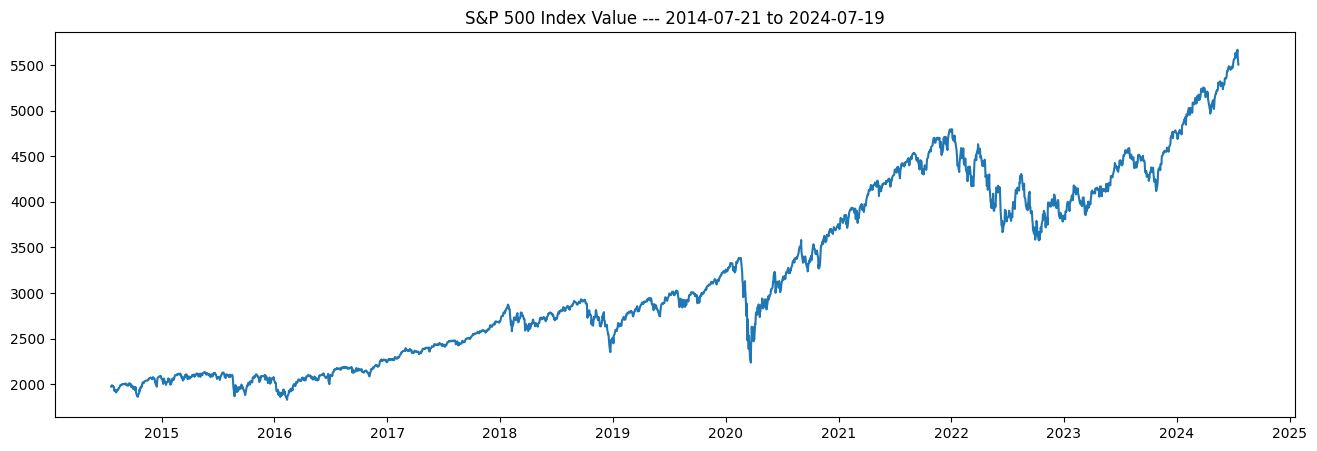

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    plt.figure(figsize=(16,5))
    plt.title("S&P 500 Index Value --- {} to {}".format(sp_index['Date'].min().date(), sp_index['Date'].max().date()))
    plt.plot(sp_index['Date'], sp_index['S&P500'])
    plt.locator_params(axis="x", nbins=15)
    plt.show(sns)

**Processing the Data**

We will be training data from 2018 through 2023, using January 2024 to evaluate the model performance.

**Note:** The input data for Prophet model must have the timestamp column labeled as ds, and the value column labeled as y.

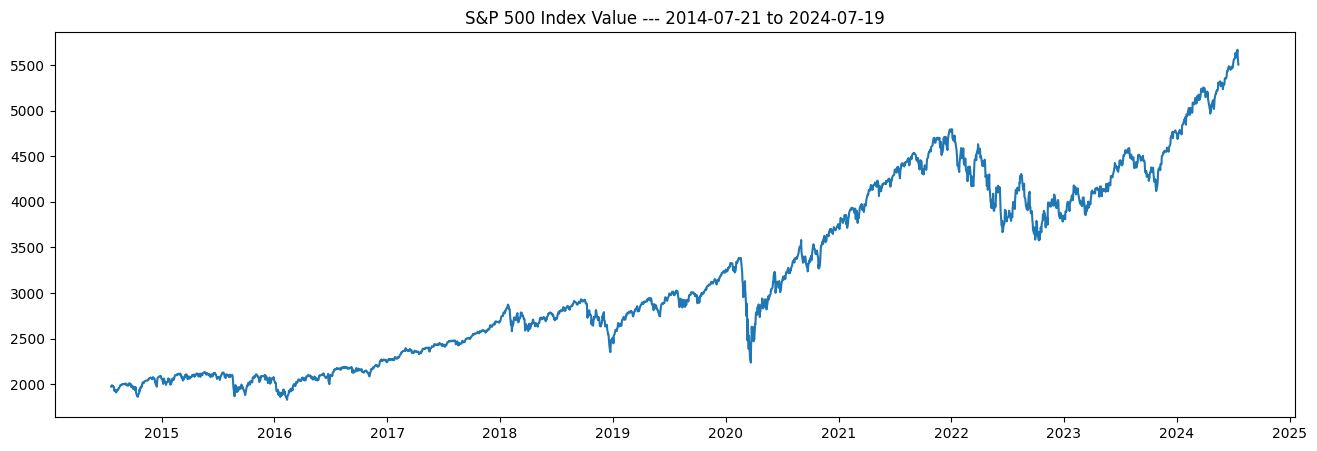

In [26]:
sp_index_copy = sp_index.copy().rename(columns={'Date':'ds', 'S&P500': 'y'}) # Create a copy of sp_index using sp_index.copy() and then call rename on that copy. Store the result in sp_index_copy
sp_train = sp_index_copy[(sp_index_copy.ds.dt.year >= 2018) & (sp_index_copy.ds.dt.year < 2024)].reset_index(drop=True).sort_values("ds")

with warnings.catch_warnings():
  warnings.simplefilter('ignore')

  plt.figure(figsize=(16,5))
  plt.title("S&P 500 Index Value --- {} to {}".format(sp_index['Date'].min().date(), sp_index['Date'].max().date()))
  plt.plot(sp_index['Date'], sp_index['S&P500'])
  plt.locator_params(axis="x", nbins=15)
  plt.show()

**Prophet Model**

Initiating Prophet Model using interval_width parameters to specify the confidence interval in our forecast, which has been set to 95% (default = 80%).

Then we will add holiday information into the forecast using Prophet's built-in collection of country-specified holidays.  With this feature we can simply pass in "US" to retrieve the holidays for the United States.  

Note: You can also manually enter these dates if needed.

Last, employ model.fit() on data to train the model.


In [28]:
model_1 = Prophet(interval_width=0.95, daily_seasonality=True)
model_1.add_country_holidays(country_name='US')
model_1.fit(sp_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/p0rnukxj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/h0ddvpk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32426', 'data', 'file=/tmp/tmpozc1xmoj/p0rnukxj.json', 'init=/tmp/tmpozc1xmoj/h0ddvpk0.json', 'output', 'file=/tmp/tmpozc1xmoj/prophet_model0houeqxu/prophet_model-20240828202544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [30]:
future = model_1.make_future_dataframe(periods=30, freq="B")
forecast = model_1.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1534,2024-02-05,4732.480672,4533.359846,4940.738440
1535,2024-02-06,4737.955454,4518.335765,4943.629863
1536,2024-02-07,4739.695721,4517.905751,4932.228741
1537,2024-02-08,4742.159862,4518.391132,4967.902780
1538,2024-02-09,4745.700559,4523.721456,4953.291510


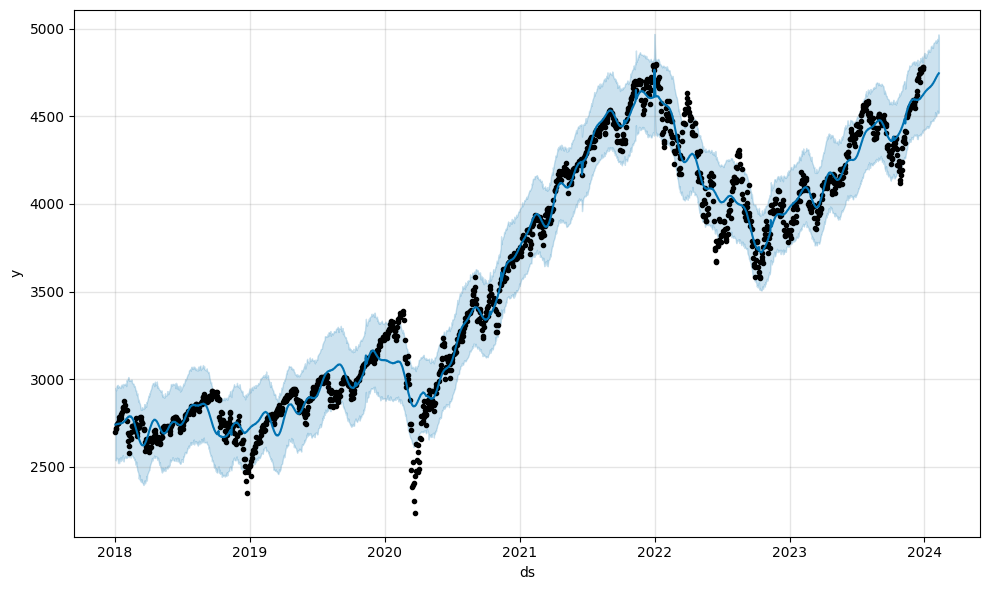

In [32]:
fig = model_1.plot(forecast)

The above plot shows a great view of the original data points, however, the forecasted values are hard to see.  To correct this problem, we will plot 120 days from the trained data and 30 days from the model predictions, for a total of 150 days of data.

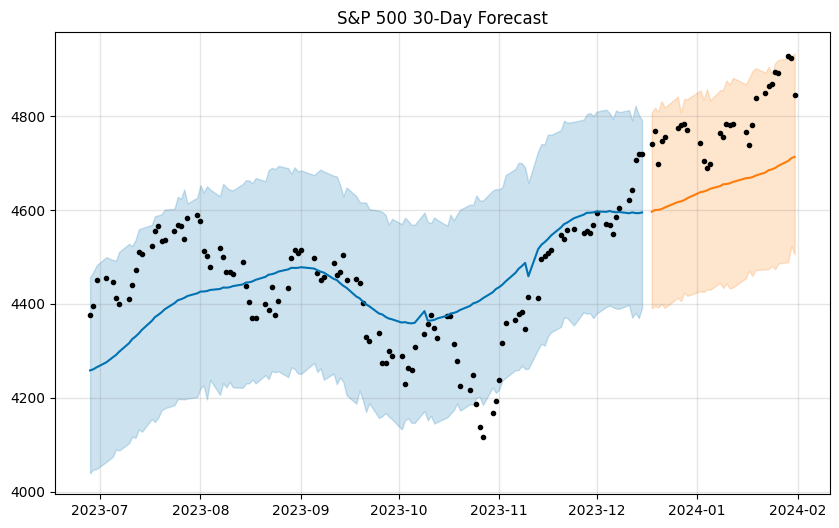

In [44]:
def custom_forecast_plot():
    forecast_length = 30

    prior_df = sp_index_copy[(sp_index_copy.ds.dt.year>=2018) & (sp_index_copy.ds.dt.year<2024)]
    forecast_df = sp_index_copy[(sp_index_copy.ds.dt.year==2024) & (sp_index_copy.ds.dt.month==1)]
    all_df = pd.concat([prior_df, forecast_df]).sort_values('ds')
    all_df.head()

    all_df_sample = all_df[-forecast_length*5:]
    forecast_sample = forecast[forecast['ds'].isin(all_df["ds"].values)].sort_values('ds')

    prior_vis_df = forecast_sample[-forecast_length*5:-forecast_length]
    forecast_vis_df = forecast_sample[-forecast_length:]

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    ax.plot(all_df_sample['ds'].dt.to_pydatetime(), all_df_sample["y"], '.k')

    ax.plot(prior_vis_df['ds'].dt.to_pydatetime(), prior_vis_df['yhat'], ls='-', c='#0072B2')
    ax.fill_between(prior_vis_df['ds'].dt.to_pydatetime(), prior_vis_df['yhat_lower'], prior_vis_df['yhat_upper'], color='#0072B2', alpha=0.2)

    ax.plot(forecast_vis_df['ds'].dt.to_pydatetime(), forecast_vis_df['yhat'], ls='-', c='#fc7d0b')
    ax.fill_between(forecast_vis_df['ds'].dt.to_pydatetime(), forecast_vis_df['yhat_lower'], forecast_vis_df['yhat_upper'], color='#fc7d0b', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

    ax.set_title('S&P 500 30-Day Forecast')
    plt.show(sns)

custom_forecast_plot()

We can see from the plot above that our predictions are slightly under what the true labels are. That being said, all but 1 of the 30 points stayed within the 95% confidence interval of the model. That's pretty good considering we are making all of these predictions 30 days in advance!

**Breaking Down the Model**

In the next plot, we can break down the model even further. The first plot shows that apart from 2020, the S&P 500 index value has a positive trend over time.

The second plot shows the effect of holidays on the data. We can see that for all but two of the holidays it seems that the value increases. It is important to note that the stock market closes on major holidays, and therefore the effect of these events may be reflected by the market on the days before and after the event.

The third plot shows that there is very little difference between each weekday in terms of how it affects the S&P 500 index value. Note that trades are not done on Saturday or Sunday so these values do not give us any additional information.

Finally, we can see that the model sees a downward trend from October to November, whereas the other months are when the index value increases. This suggests that the model could be overfitting to the seasonality of the training data, or the stock market could have a moderate yearly seasonality2.

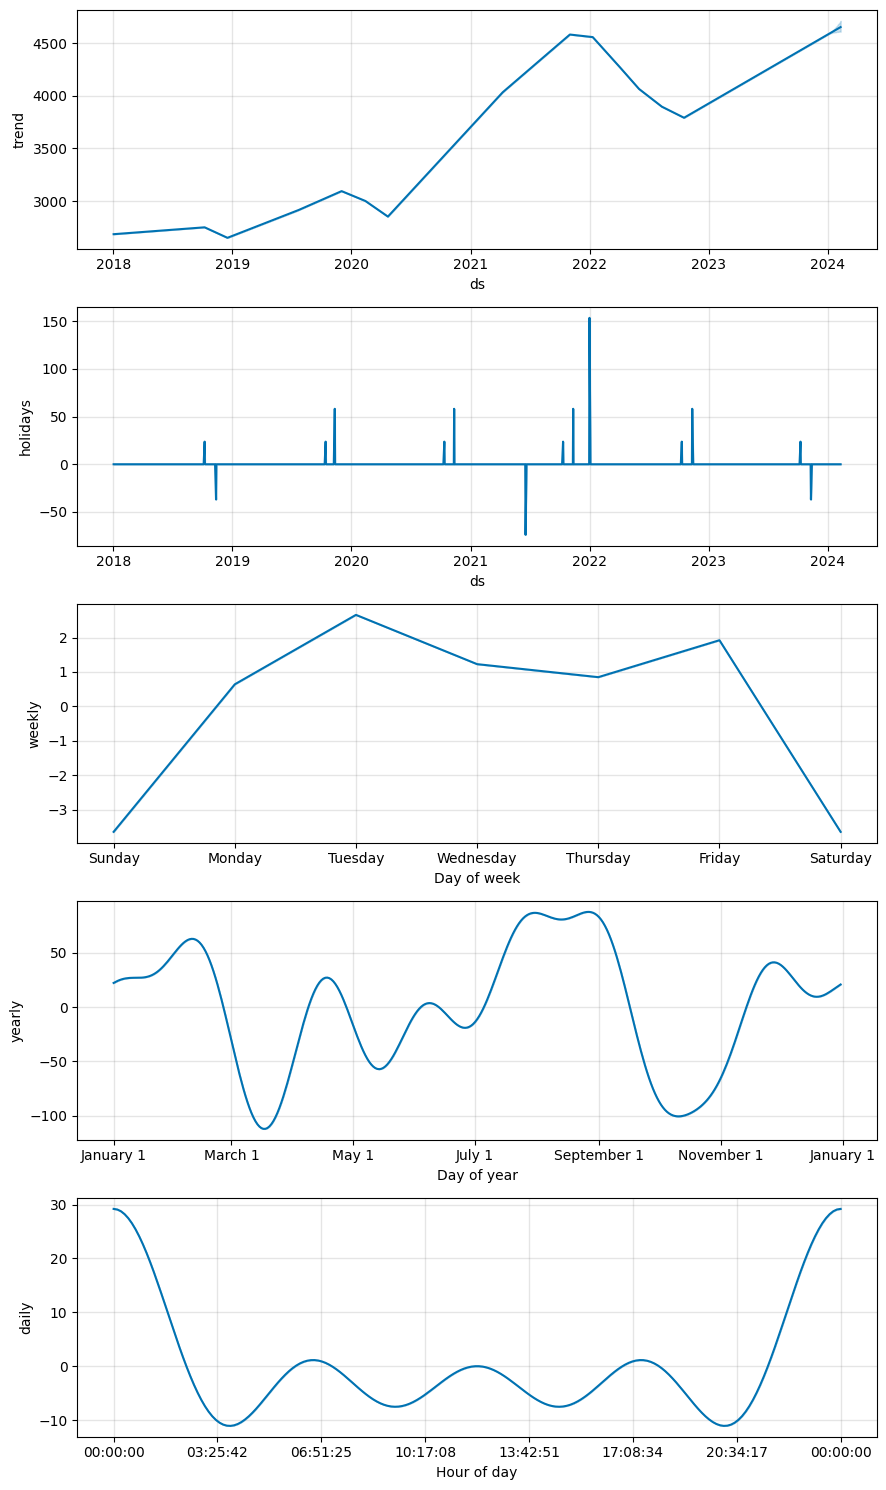

In [46]:
fig = model_1.plot_components(forecast)

Automatic changepoint detection in Prophet
Prophet automatically detects changepoints when creating the data trend. It first gets a large number of potential changepoints where the rate changes, then it uses a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) to reduce the number of changepoints.

By default, Prophet adds 25 potential changepoints which are uniformly placed in the first 80% of the time-series data. This is done so that the model does not overfit the most recent data points. The default changepoint_range parameter works for most problems but can be changed when instantiating the model. In the following cell, we are plotting the changepoints of the fit model.

Note: You can also simply print the changepoints with "model.changepoints"

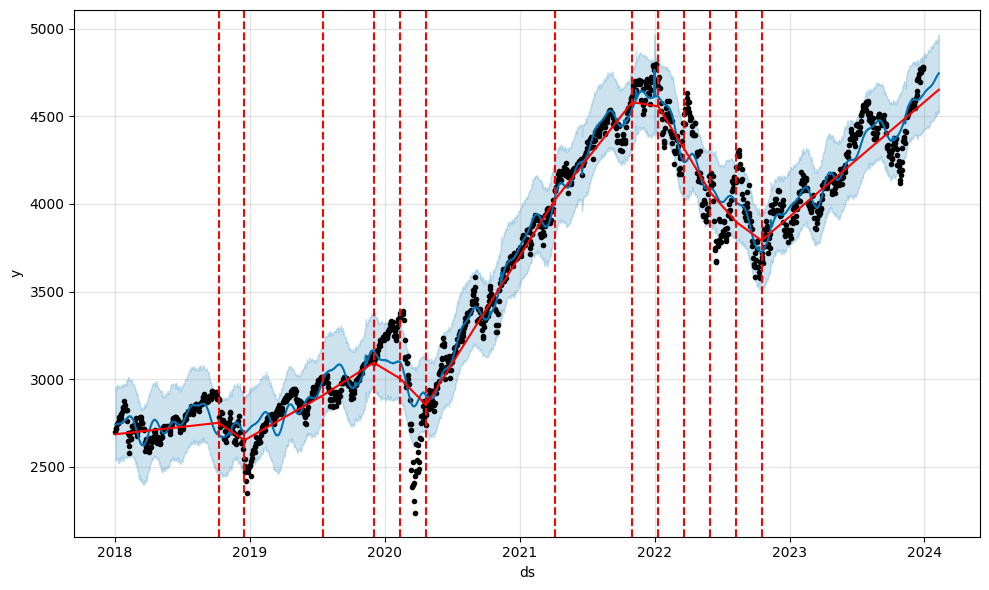

In [47]:
fig = model_1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_1, forecast)

Adjusting Trend Flexibility
Another part of the prophet framework that we will explore is adjusting the trend flexibility. This allows us to manually adjust the effect that the trend has on the model. In some cases, we may want to fit more to the trend, and in others we would not. We can adjust this with the changepoint_prior_scale parameter (default: 0.05).

In the following cell, we enter a changepoint_prior_scale value of 0.001. We can see that the model is not following the general trend as much and is rather fitting more to the seasonality.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/obanx6yo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/sy_726hu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43261', 'data', 'file=/tmp/tmpozc1xmoj/obanx6yo.json', 'init=/tmp/tmpozc1xmoj/sy_726hu.json', 'output', 'file=/tmp/tmpozc1xmoj/prophet_model1f5q16rk/prophet_model-20240828210411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


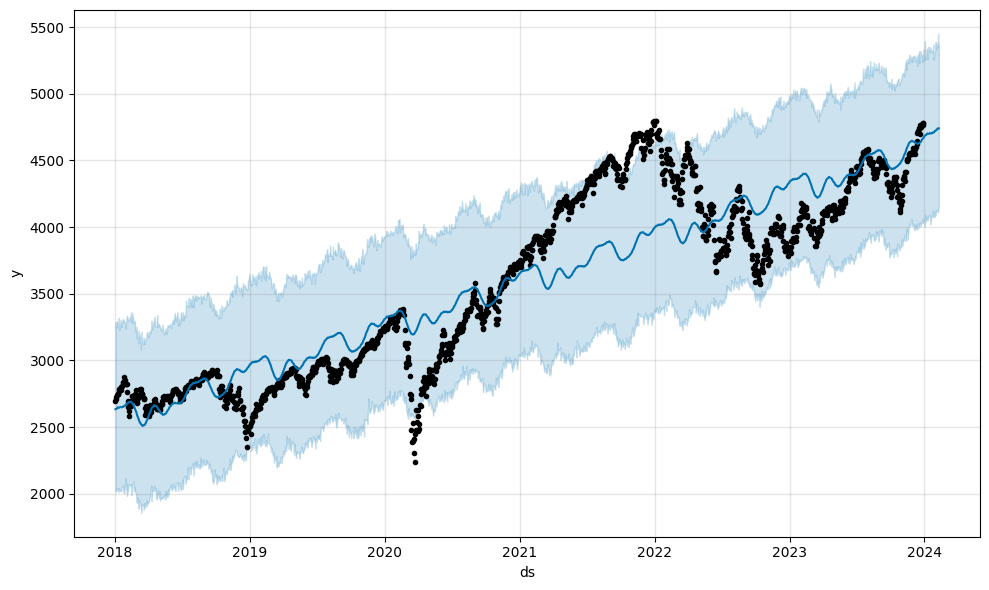

In [49]:
model_2 = Prophet(interval_width=0.95, changepoint_prior_scale=0.001)
model_2.add_country_holidays(country_name='US')
forecast = model_2.fit(sp_train).predict(future)
fig = model_2.plot(forecast)

We can then use the custom_forecast_plot() function that we created earlier in the article to visualize the forecast for the following 30-day period.

We can see that the model is influenced very little by the latest change points, and relies more on the seasonality found in the training data. We can say that the model is underfitting the trend.

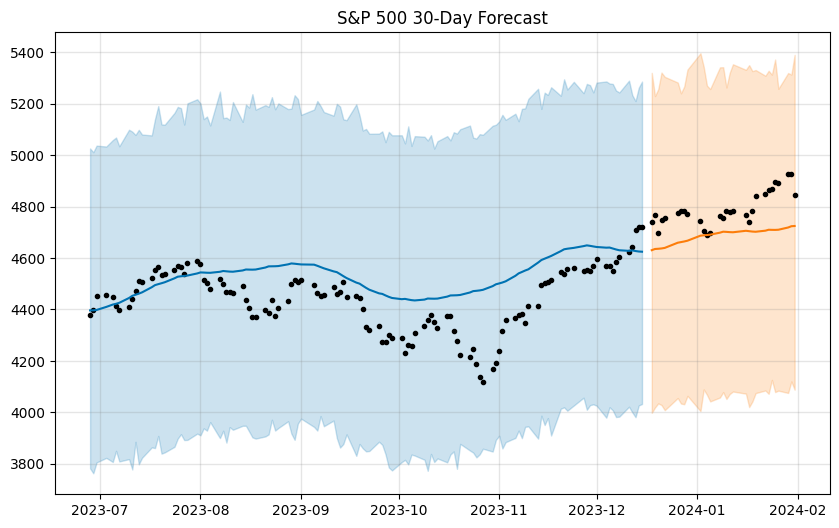

In [50]:
custom_forecast_plot()

We can also increase the value of the changepoint_prior_scale value to magnify the effect of the trend on the forecast.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/1bnb_c98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/42qwk68s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6729', 'data', 'file=/tmp/tmpozc1xmoj/1bnb_c98.json', 'init=/tmp/tmpozc1xmoj/42qwk68s.json', 'output', 'file=/tmp/tmpozc1xmoj/prophet_modeljxj7kq82/prophet_model-20240828210622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:06:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


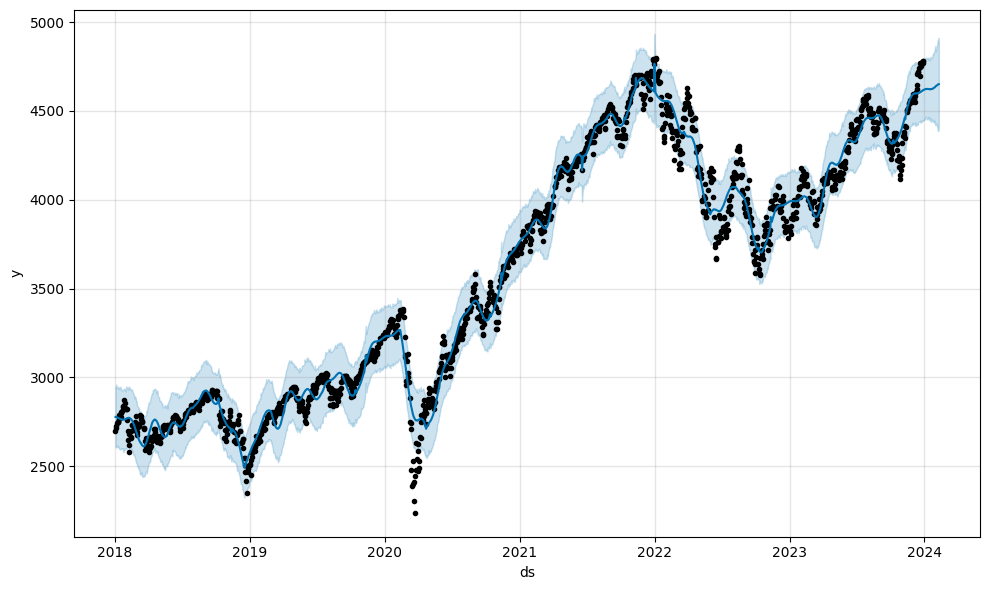

In [52]:
model_3 = Prophet(interval_width=0.95, changepoint_prior_scale=0.99)
model_3.add_country_holidays(country_name='US')
forecast = model_3.fit(sp_train).predict(future)
fig = model_3.plot(forecast)

We can see that in this case, the model actually has a decent forecast at the start of the 30-day period that we are predicting. That being said, the model is under predicting the value of the index in the latter part of the prediction and could be overfitting the data.

Finding a changepoint_prior_scale value that is optimal for each use case is difficult, and requires a balance of domain knowledge, statistics, and luck in tuning this parameter. It is also important to take into account how far into the future the model needs to forecast.

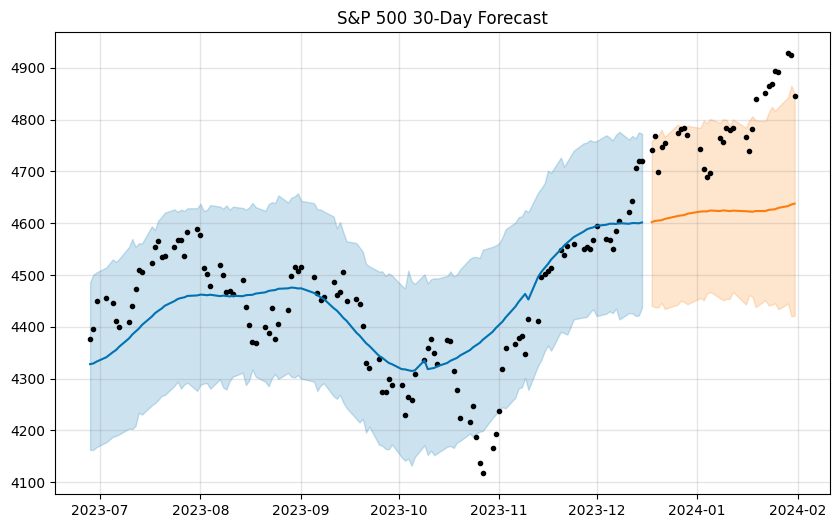

In [53]:
custom_forecast_plot()

The default value of 0.05 for the changepoint_prior_scale parameter seems to work well for this data so we will not tune that further.

Adjusting Seasonality
A significant part of the Prophet model is its incorporation of seasonality. There are many ways we can tune this.

First of all, the seasonality_prior_scale parameter (default: 10) adjusts how much the model uses seasonality in its forecast. In the following cell, let's decrease this value and see how it affects the model forecast.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/3r6t0369.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpozc1xmoj/pljg_dtj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13901', 'data', 'file=/tmp/tmpozc1xmoj/3r6t0369.json', 'init=/tmp/tmpozc1xmoj/pljg_dtj.json', 'output', 'file=/tmp/tmpozc1xmoj/prophet_modelcn7ivvff/prophet_model-20240828210713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:07:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:07:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


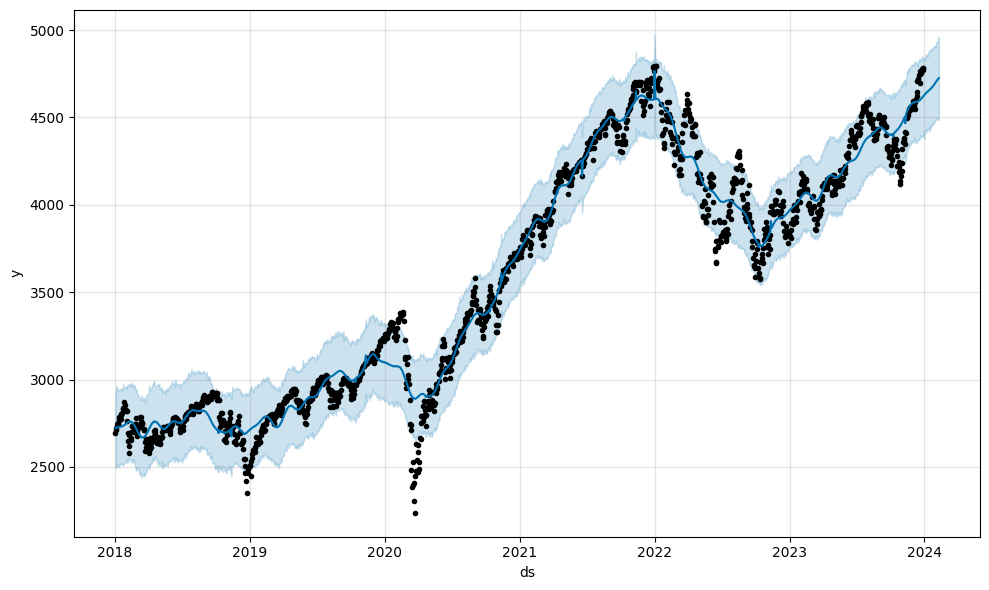

In [54]:
model_4 = Prophet(interval_width=0.95, seasonality_prior_scale=0.001)
model_4.add_country_holidays(country_name='US')
forecast = model_4.fit(sp_train).predict(future)
fig = model_4.plot(forecast)

We can see in the cell above that the model is less affected by seasonality and more closely follows the trend of the data. This is evident when we plot the 30-day forecast after training the model. The prediction is very close to a straight line.

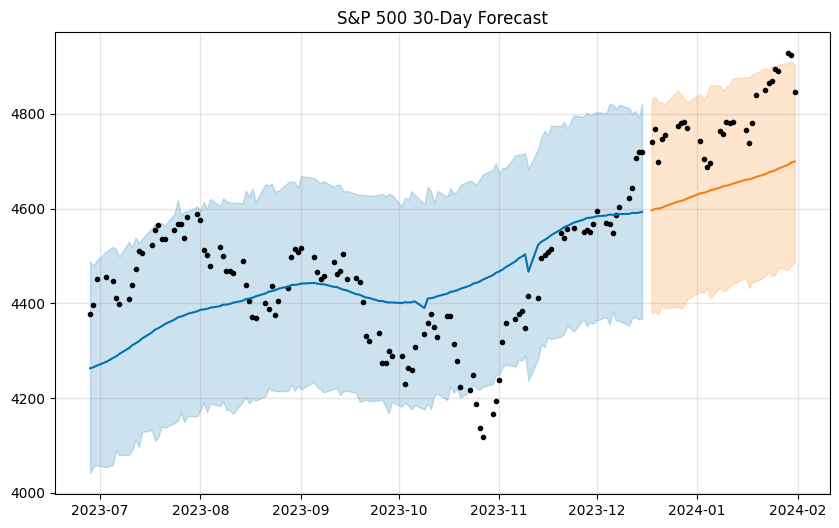

In [55]:
custom_forecast_plot()